In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.express as px
from wordcloud import WordCloud,STOPWORDS
from joblib import dump, load

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

import spacy
from tqdm import tqdm



In [2]:
data_dir = 'BG3_reviews_updated.csv'
ds_name = 'BG3'

In [3]:
df = pd.read_csv(data_dir)
df.head()

recommendationid language  \
0         153560814  english   
1         153560623  english   
2         153560414  english   
3         153560343  english   
4         153559963  english   

                                              review  timestamp_created  \
0          This game hits all the right marks. 10/10         1702542971   
1     took me like 11 hours to understand the basics         1702542657   
2  10/10 game play and story! It's my first turn ...         1702542275   
3                               gale is so baby girl         1702542158   
4                    YES,\n\nWITHOUT A F****N DOUBT.         1702541518   

   timestamp_updated  voted_up  votes_up  votes_funny  weighted_vote_score  \
0         1702542971      True         0            0                  0.0   
1         1702542657      True         0            0                  0.0   
2         1702542275      True         0            0                  0.0   
3         1702542158      True         0            0                  0.0   
4         1702541518      True         0            0                  0.0   

   written_during_early_access  comment_count  steam_purchase  \
0                        False              0            True   
1                        False              0            True   
2                        False              0            True   
3                        False              0            True   
4                        False              0            True   

   received_for_free  
0              False  
1              False  
2              False  
3              False  
4              False

In [4]:
def ds_shape(df, ds_name='df'):
    print(f"The {ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} Columns")

ds_shape(df, ds_name)

The BG3 dataset has 309103 rows and 13 Columns


In [5]:
def ds_info(df, ds_name='df'):
    print(f"The {ds_name} dataset info:\n")
    print(df.info())
    
ds_info(df, ds_name)

The BG3 dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309103 entries, 0 to 309102
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   recommendationid             309103 non-null  int64  
 1   language                     309103 non-null  object 
 2   review                       308086 non-null  object 
 3   timestamp_created            309103 non-null  int64  
 4   timestamp_updated            309103 non-null  int64  
 5   voted_up                     309103 non-null  bool   
 6   votes_up                     309103 non-null  int64  
 7   votes_funny                  309103 non-null  int64  
 8   weighted_vote_score          309103 non-null  float64
 9   written_during_early_access  309103 non-null  bool   
 10  comment_count                309103 non-null  int64  
 11  steam_purchase               309103 non-null  bool   
 12  received_for_free            309103

In [6]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())
    
check_null(df, ds_name)

Null Values in each col in the BG3 dataset:

recommendationid                  0
language                          0
review                         1017
timestamp_created                 0
timestamp_updated                 0
voted_up                          0
votes_up                          0
votes_funny                       0
weighted_vote_score               0
written_during_early_access       0
comment_count                     0
steam_purchase                    0
received_for_free                 0
dtype: int64


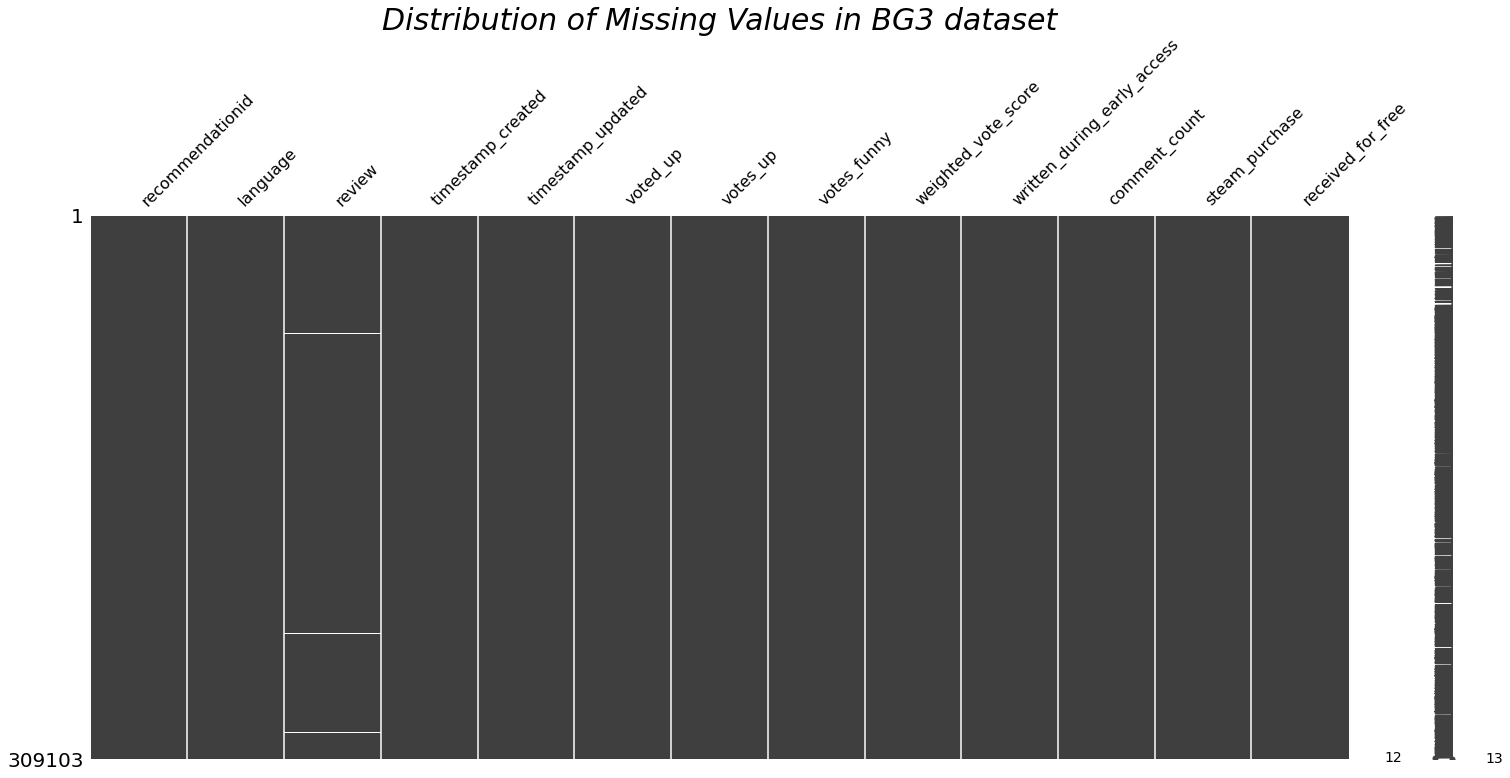

In [7]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()
    
plot_miss_vals(df, ds_name)

In [8]:
def uni_vals(df, ds_name='df'):
    
    print(f"The number of unique values in each column in {ds_name} dataset:\n")
    print(df.nunique())

uni_vals(df, ds_name)

The number of unique values in each column in BG3 dataset:

recommendationid               309103
language                            1
review                         255104
timestamp_created              302240
timestamp_updated              301372
voted_up                            2
votes_up                          424
votes_funny                       190
weighted_vote_score             15577
written_during_early_access         2
comment_count                      68
steam_purchase                      2
received_for_free                   2
dtype: int64


In [9]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)
    
    
colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

In [10]:
cat_features = []
cont_features = []
ind = len(df.nunique())
for i in range(ind):
    
    if df.nunique().values[i] <= 25:
        cat_features.append(df.nunique().index[i])
        
    else:
        cont_features.append(df.nunique().index[i])

In [11]:
for cat_feature in cat_features:
    cat_summary_with_graph(df, cat_feature)


In [12]:
def wordcloud_vis(df, col_name):
    
    plt.figure(figsize=(20, 20)) 
    wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df[col_name]))
    plt.imshow(wc, interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    plt.show()

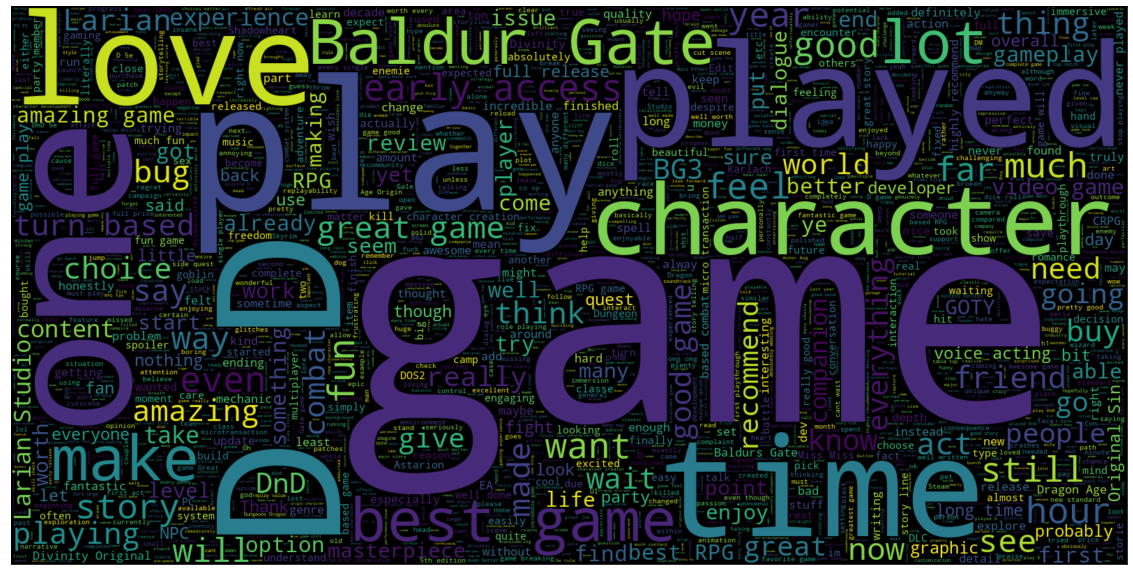

In [13]:
wordcloud_vis(df.dropna(), 'review')


In [14]:
def number_letters(df, col_name):
    
    letters_len=df[col_name].str.len()
    plt.hist(letters_len,color='red')
    plt.title("Distrbution of Number of letters in each text")
    plt.xlabel("Num of letters")
    plt.ylabel("Frequency")
    plt.show()

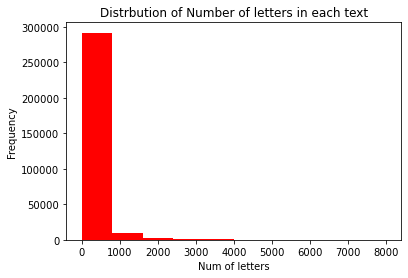

In [15]:
number_letters(df.dropna(), 'review')


In [16]:
def number_words(df, col_name):
    
    words_len=df[col_name].str.split().map(lambda x: len(x))
    plt.hist(words_len,color='green')
    plt.title("Distrbution of Number of words in each text")
    plt.xlabel("Num of words")
    plt.ylabel("Frequency")
    plt.show()

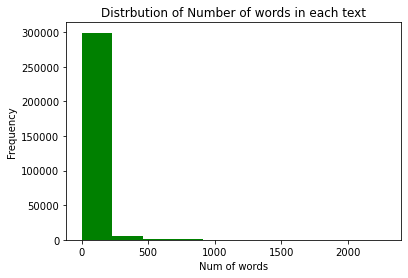

In [17]:
number_words(df.dropna(), 'review')


In [18]:
def avg_word_len(df, col_name):
    
    word=df[col_name].str.split().apply(lambda x : [len(i) for i in x])
    word = word.map(lambda x: np.mean(x))
    sns.distplot(word,color='red')
    plt.title("Average word length in each text")
    plt.xlabel("Word length")
    plt.ylabel("Precentage")
    plt.show()

C:\Users\himanshu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

C:\Users\himanshu\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\himanshu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



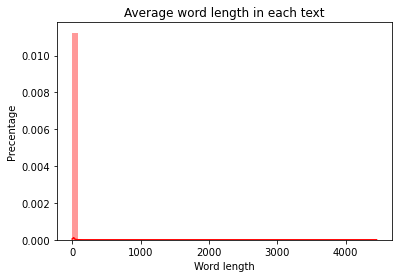

In [19]:
avg_word_len(df.dropna(), 'review')


In [20]:
df.dropna(inplace=True)



In [21]:
df['review'] = df['review'].str.lower()



In [22]:
grouped = df[['review', 'voted_up']].groupby('voted_up')
min_num = df['voted_up'].value_counts().values[len(df['voted_up'].unique())-1]


for cat, group in grouped:
    sampled_rows = group.sample(n=min_num, replace=True, random_state=123)  # Sampling 1000 rows from each category
    if not cat:
        fal = sampled_rows
    else:
        true = sampled_rows

In [23]:
df2 = pd.concat([fal, true])
df2.head()


review  voted_up
149894       dont equip the face paint it never goes away     False
74788   the game crashes a ton once you reach act 2, i...     False
206262           dragonborn penis customization: lacking.     False
275782  if i had not already invested the money i woul...     False
304807  it doesn't feel like dnd or baldur's gate. it ...     False

In [24]:
df2['voted_up'].value_counts()


False    10157
True     10157
Name: voted_up, dtype: int64

In [25]:
nlp = spacy.load('en_core_web_lg')


In [26]:
def preprocess(text):
    
    doc = nlp(text)
    filtered_tokens = []
    
    for token in doc:
        
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    
    return ' '.join(filtered_tokens)


In [27]:
df2['preprcessed_review'] = df2['review'].apply(preprocess)



In [30]:
embeddings_index = {}
f = open('glove.840B.300d.txt',encoding='utf-8')

for line in tqdm(f):
    
     values = line.split()
        
     if len(values) < 2:
         continue  # Skip lines with insufficient data
     word = values[0]
    
     try:
         coefs = np.asarray(values[1:], dtype='float32')
     except ValueError:
         pass
        
     embeddings_index[word] = coefs
    
f.close()

2196018it [03:38, 10067.63it/s]


In [31]:
embeddings_index['great']


array([-9.3846e-02,  5.8296e-01, -1.9271e-02, -7.0072e-02,  1.8095e-01,
        1.5343e-01,  1.7444e-01, -1.8207e-01, -6.6300e-02,  2.3681e+00,
       -1.2753e-01,  1.7784e-02,  1.0581e-01,  1.9629e-01, -2.5103e-01,
       -2.7987e-01, -2.9529e-01,  1.1575e+00, -2.0997e-01,  8.3031e-02,
       -2.6101e-02, -2.3911e-01,  2.7443e-01, -2.2339e-01, -4.9437e-02,
        1.9215e-01,  1.2176e-01,  2.2273e-01, -1.2051e-01,  1.9972e-01,
        2.1834e-01,  3.0302e-01, -1.7650e-02,  6.6369e-02,  1.5469e-01,
       -2.7746e-01,  2.9550e-01, -3.5517e-01, -3.6803e-01, -2.1441e-01,
       -1.6825e-02,  3.2859e-01, -1.6417e-01, -4.3756e-02,  3.2168e-01,
        4.7823e-01, -3.0072e-01,  3.5865e-01,  1.8450e-01, -1.1995e-01,
       -4.8905e-02,  3.7055e-01,  4.4224e-01,  1.7276e-01,  1.8705e-01,
        2.3734e-01,  5.5195e-03,  1.5334e-01, -8.0614e-02, -9.8517e-04,
       -1.3972e-01, -5.1074e-01, -1.0340e-01,  4.5437e-01,  6.5120e-02,
       -1.9894e-01,  2.0476e-01,  2.5925e-01,  1.5235e-01,  6.99

In [32]:
def sent2vec(s):
    
    words = nlp(s)
    
    vectorized_sentence = []
    for w in words:
        try:
            vectorized_sentence.append(embeddings_index[w.text])
        except:
            continue
            
    vectorized_sentence = np.array(vectorized_sentence)
    v = vectorized_sentence.sum(axis=0)
    
    if type(v) != np.ndarray:
        return np.zeros(300)
    
    return v / np.sqrt((v ** 2).sum())

In [33]:
sent2vec('good enough')


array([-6.96371645e-02,  6.47016913e-02, -6.34144396e-02, -1.06560923e-02,
       -3.59634906e-02,  3.58941741e-02, -6.09998358e-03, -2.36510988e-02,
        4.49339906e-03,  4.97921109e-01, -1.67094562e-02,  2.65213065e-02,
        1.04072057e-02,  3.85905877e-02, -7.70254284e-02, -1.27463220e-02,
       -2.45847646e-02,  2.19037220e-01, -3.48691270e-02,  1.59562379e-02,
        6.28564274e-03,  2.31951964e-03,  4.81531359e-02, -6.95319548e-02,
       -4.05117609e-02,  7.74771953e-03,  8.25220067e-03, -3.51507068e-02,
        6.86294362e-02, -7.68201649e-02, -1.14263790e-02,  1.79688521e-02,
       -2.80719865e-02, -1.63441151e-02,  3.12204808e-02, -1.86241306e-02,
        5.58219589e-02,  1.28002674e-03, -3.00260223e-02, -4.06184122e-02,
       -2.74530216e-03,  3.52229103e-02, -3.72600183e-02, -3.72115411e-02,
        5.25997095e-02,  1.76809747e-02, -1.97912119e-02,  2.87113804e-02,
       -1.15273576e-02, -2.53755748e-02, -3.10133640e-02,  7.71770477e-02,
        5.76930009e-02, -

In [34]:
df2['preprocessed_vectroizer'] = df2['preprcessed_review'].apply(sent2vec)


In [35]:
df2.head()


review  voted_up  \
149894       dont equip the face paint it never goes away     False   
74788   the game crashes a ton once you reach act 2, i...     False   
206262           dragonborn penis customization: lacking.     False   
275782  if i had not already invested the money i woul...     False   
304807  it doesn't feel like dnd or baldur's gate. it ...     False   

                                       preprcessed_review  \
149894                       not equip face paint go away   
74788   game crash ton reach act 2 shame publisher rel...   
206262                dragonborn penis customization lack   
275782  invest money buy \n story line incomplete \n f...   
304807  feel like dnd baldur gate feel like divinity 3...   

                                  preprocessed_vectroizer  
149894  [0.021724327, -0.028955132, -0.025605172, -0.0...  
74788   [-0.063034564, 0.055651754, -0.026175858, -0.0...  
206262  [-0.08938091, -0.01168444, -0.033156812, 0.036...  
275782  [-0.039042246, 0.029422637, -0.03649117, -0.00...  
304807  [-0.02613023, 0.02146523, -0.03010138, -0.0182...

In [36]:
glove_data_pre = np.stack(df2['preprocessed_vectroizer'].values)


In [37]:
lbl_enc = LabelEncoder()
df2['encoded_labels'] = lbl_enc.fit_transform(df2['voted_up'].values)
df2.head()


review  voted_up  \
149894       dont equip the face paint it never goes away     False   
74788   the game crashes a ton once you reach act 2, i...     False   
206262           dragonborn penis customization: lacking.     False   
275782  if i had not already invested the money i woul...     False   
304807  it doesn't feel like dnd or baldur's gate. it ...     False   

                                       preprcessed_review  \
149894                       not equip face paint go away   
74788   game crash ton reach act 2 shame publisher rel...   
206262                dragonborn penis customization lack   
275782  invest money buy \n story line incomplete \n f...   
304807  feel like dnd baldur gate feel like divinity 3...   

                                  preprocessed_vectroizer  encoded_labels  
149894  [0.021724327, -0.028955132, -0.025605172, -0.0...               0  
74788   [-0.063034564, 0.055651754, -0.026175858, -0.0...               0  
206262  [-0.08938091, -0.01168444, -0.033156812, 0.036...               0  
275782  [-0.039042246, 0.029422637, -0.03649117, -0.00...               0  
304807  [-0.02613023, 0.02146523, -0.03010138, -0.0182...               0

In [38]:
label_mapping = {label: encoded for label, encoded in zip(lbl_enc.classes_, lbl_enc.transform(lbl_enc.classes_))}
label_mapping


{False: 0, True: 1}

In [39]:
dump(label_mapping, 'label_mapping_dict.pkl')


['label_mapping_dict.pkl']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    glove_data_pre,
    df2['encoded_labels'].values,
    random_state=123,
    test_size=0.2,
    shuffle=True,
    stratify=df2['encoded_labels'].values)

In [41]:
print(f"We have {X_train.shape[0]} Training datasets and {X_test.shape[0]} Testing datasets.")


We have 16251 Training datasets and 4063 Testing datasets.


In [42]:
def modeling(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f"Model Accuarcy: {score*100}%")
    return y_pred

In [43]:
xgboost_model = XGBClassifier()
xgboost_ypred = modeling(xgboost_model, X_train, y_train, X_test, y_test)

Model Accuarcy: 90.22889490524243%


In [44]:
rf_model = RandomForestClassifier()
rf_ypred = modeling(rf_model, X_train, y_train, X_test, y_test)

Model Accuarcy: 90.1550578390352%


In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
knc_model = KNeighborsClassifier()
knc_ypred = modeling(knc_model, X_train, y_train, X_test, y_test)

Model Accuarcy: 83.48510952498154%


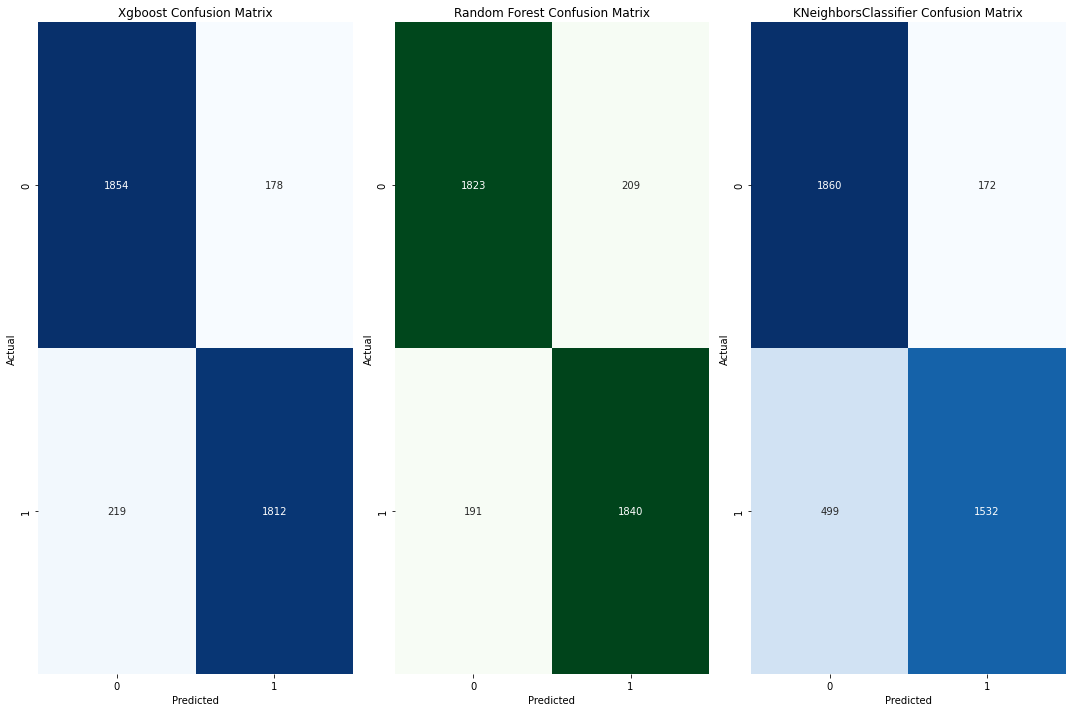

In [71]:
xgboost_conf_matrix = confusion_matrix(y_test, xgboost_ypred)
rf_conf_matrix = confusion_matrix(y_test, rf_ypred)
knc_conf_matrix = confusion_matrix(y_test, knc_ypred)

# Plot confusion matrices
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
sns.heatmap(xgboost_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Xgboost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.heatmap(rf_conf_matrix, annot=True, cmap='Greens', fmt='d', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
sns.heatmap(knc_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('KNeighborsClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()

In [72]:
def class_report(y_test, y_pred):
    print(classification_report(y_test, y_pred))

In [73]:
class_report(y_test, xgboost_ypred)


              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2032
           1       0.91      0.89      0.90      2031

    accuracy                           0.90      4063
   macro avg       0.90      0.90      0.90      4063
weighted avg       0.90      0.90      0.90      4063



In [74]:
class_report(y_test, rf_ypred)


              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2032
           1       0.90      0.91      0.90      2031

    accuracy                           0.90      4063
   macro avg       0.90      0.90      0.90      4063
weighted avg       0.90      0.90      0.90      4063



In [75]:
class_report(y_test, knc_ypred)


              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2032
           1       0.90      0.75      0.82      2031

    accuracy                           0.83      4063
   macro avg       0.84      0.83      0.83      4063
weighted avg       0.84      0.83      0.83      4063



In [76]:
dump(xgboost_model, 'model.joblib')


['model.joblib']

In [77]:
model = load('model.joblib')
loaded_label_mapping = load('label_mapping_dict.pkl')

In [78]:
def predict(text, label_mapping, model):
    
    preprocessed_text = preprocess(text)
    transformed_text = sent2vec(preprocessed_text)
    result = model.predict([transformed_text])
    decoded_label = list(label_mapping.keys())[list(loaded_label_mapping.values()).index(result)]
    
    if bool(decoded_label):
        print("The Review is Positive.")
    else:
        print("The Review is Negative")


In [79]:
text = df2['review'][79306]
true_label = df2['voted_up'][79306]
print(text)

best game i've played in a very long time, would highly recommend it to anyone


In [80]:
print(f"True Label is {true_label}")
print("-"*50)
print("Model Results:")
predict(text, loaded_label_mapping, model)


True Label is True
--------------------------------------------------
Model Results:
The Review is Positive.


In [81]:
text = df['review'][74788]
true_label = df['voted_up'][74788]
print(text)

the game crashes a ton once you reach act 2, it is a shame the publisher even released it. i do not pay $60 just to become a tester. yes it is a good game with lots of content and great graphics, but the quality of the game itself after act 1 really lowered all my expectations. you can't win any awards for releasing an unfinished product. go back to the lab and actually finish the game before releasing it please.


In [82]:
print(f"True Label is {true_label}")
print("-"*50)
print("Model Results:")
predict(text, loaded_label_mapping, model)

True Label is False
--------------------------------------------------
Model Results:
The Review is Negative
